In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import glob
import dask.dataframe as dd
import seaborn as sns
import pickle
import pysam
import numpy as np
from collections import defaultdict
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sequencing_tools.fastq_tools import reverse_complement
from sklearn.metrics import mean_squared_error
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})


def count_to_nuc(miR_count_dict):
    '''
    input:
    counts: dict(miRNA:counts[:])
    
    output:
    table:
        pd.DataFrame(pos[:], base[:], counts[:])
    '''
    
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    nuc_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for ref in fa.references:
        seq = fa[ref]
        read1 = seq[:15]
        read2 = reverse_complement(seq)[:15]
    
        for i, (b, rb) in enumerate(zip(read1, read2)):
            nuc_dict['read1'][i][b] += miR_count_dict[ref]
            nuc_dict['read2'][i][rb] += miR_count_dict[ref]

    dfs = []
    for read, read_dict in nuc_dict.items():
        for pos, pos_dict in read_dict.items():
            dfs.append(pd.DataFrame({'base': list(pos_dict.keys()),
                         'base_count':list(pos_dict.values())})\
                .assign(end = read, pos = pos))
            
    return pd.concat(dfs) \
        .assign(base_fraction = lambda d: d.groupby(['end','pos']).base_count.transform(lambda x: x/x.sum())) 



def expected_nuc():
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    mir_dict = {}
    for ref in fa.references:
        mir_dict[ref] = 1
    
    return count_to_nuc(mir_dict) \
        .rename(columns={'base_count':'expected_base_count',
                        'base_fraction':'expected_base_fraction'})

In [14]:
NTA=''
project_path = '/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR'
table_name = project_path + '/mir_count{NTA}.feather'.format(NTA=NTA)
df = pd.read_feather(table_name)\
    .filter(regex='mir|NTT[0-9]+_corrected')
df.to_csv(table_name.replace('.feather','.csv'),
            index=False, sep=',')
df.head()

,mir,NTT1_corrected,NTT2_corrected,NTT3_corrected
0,EBV-1-1,194.577187,300.772102,184.613363
1,EBV-1-2,10344.458473,10275.654846,10758.264662
2,EBV-1-2-star,1164.725217,1001.000856,1049.842389
3,EBV-1-3,1000.958619,987.820658,1019.869894
4,EBV-1-3P,1209.200717,1070.728995,1626.773709


In [15]:
NTA=''
project_path = '/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR'
df = pd.read_feather(project_path + '/mir_count{NTA}.feather'.format(NTA=NTA)) \
    .fillna(0)\
    .pipe(pd.melt, id_vars = 'mir', var_name = 'sn', value_name = 'mir_count') \
    .pipe(lambda d: d[d.sn.str.contains('NTT')])  \
    .assign(process = lambda d: np.where(d.sn.str.contains('corrected'),
                                        'After reweighting',
                                        'Before reweighting'))\
    .groupby(['mir','process'], as_index=False)\
    .agg({'mir_count':'sum'})
df.head()

,mir,process,mir_count
0,EBV-1-1,After reweighting,679.962653
1,EBV-1-1,Before reweighting,401.000000
2,EBV-1-2,After reweighting,31378.377981
3,EBV-1-2,Before reweighting,42652.000000
4,EBV-1-2-star,After reweighting,3215.568462


In [16]:
dfs = []
for sn, sn_df in df.groupby('process'):
    mir_dict = {m:c for m, c in zip(sn_df.mir, sn_df.mir_count)}
    mir_d = count_to_nuc(mir_dict) \
        .assign(process = sn)
    dfs.append(mir_d)
mir_df = pd.concat(dfs)  \
    .merge(expected_nuc(), on=['base','pos','end']) \
    .assign(fraction = lambda d: d.base_fraction/d.expected_base_fraction)  \
    .assign(end = lambda d: d.end.str.capitalize()) \
    .assign(pos = lambda d: d.pos + 1)\
    .query('pos < 7') \
    .assign(pos = lambda d: np.where(d.end=="Read2", 7-d.pos,d.pos)) \
    .assign(base = lambda d: np.where(d.end=="Read2", [reverse_complement(b) for b in d.base],d.base))\
    .assign(base = lambda d: d.base.str.replace('T','U')) 
mir_df.head()

,base,base_count,end,pos,base_fraction,process,expected_base_count,expected_base_fraction,fraction
0,U,1.160100e+07,Read1,1,0.540524,After reweighting,402,0.417879,1.293492
1,U,2.082189e+07,Read1,1,0.611063,Before reweighting,402,0.417879,1.462295
2,A,3.862061e+06,Read1,1,0.179944,After reweighting,284,0.295218,0.609530
3,A,4.766454e+06,Read1,1,0.139882,Before reweighting,284,0.295218,0.473825
4,G,3.270928e+06,Read1,1,0.152402,After reweighting,122,0.126819,1.201726


Plotted ../figures/reweighted_nucleotide.eps


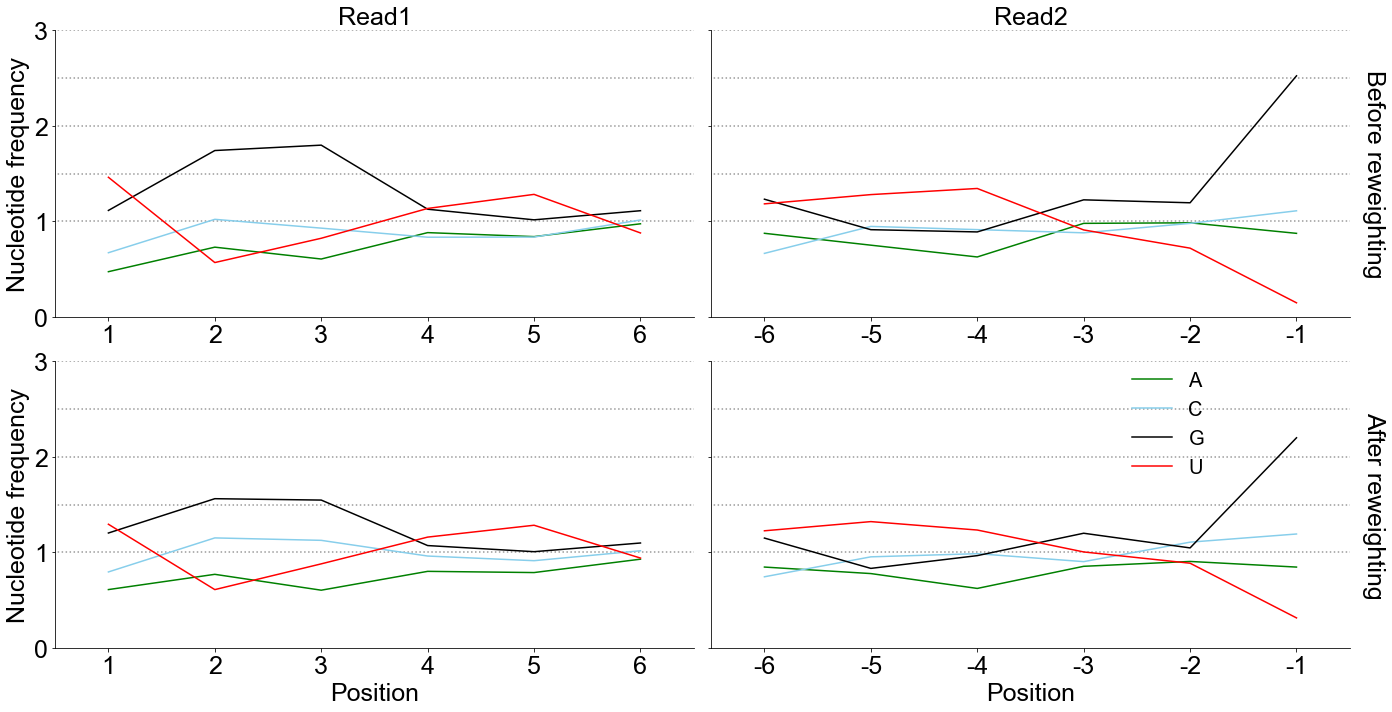

In [17]:
p = sns.FacetGrid(data=mir_df, row='process', hue = 'base',
             palette = ['green','skyblue','black', 'red'],
             col_order = ['Read1','Read2'],
             row_order = ['Before reweighting', 'After reweighting'],
             hue_order = ['A','C','G','U'],
             col= 'end',aspect=2, height=5,
             sharex=False,
             margin_titles=True)
p.map(plt.plot, 'pos', 'fraction')
for i, ax in enumerate(p.fig.axes):
    ax.hlines(xmin=0, xmax=16, y=[1,1.5,2,2.5,3],linestyle=':', color='grey', alpha=0.8)
    if i in {1,3}:
        ax.set_xticklabels(range(-7,0))
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=25)
p.add_legend(fontsize=20,title='', bbox_to_anchor=(0.8,0.4))
p.set_axis_labels('Position', 'Nucleotide frequency')
p.set(xlim=(.5,6.5), ylim=(0,3))
figname = '../figures/reweighted_nucleotide{NTA}.eps'.format(NTA=NTA)
p.savefig(figname, bbox_inches='tight')
print('Plotted %s' %figname)